In [86]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
def f(x):
    return 3*x**2 - 4*x + 5

In [88]:
f(3.0)

20.0

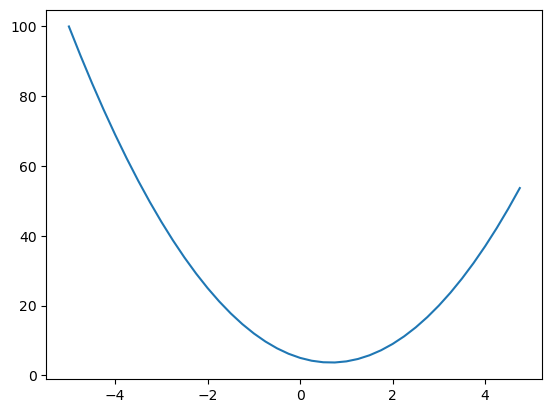

In [89]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(xs, ys)

In [90]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [91]:
# Lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [92]:
h = 0.0001 

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c    

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)



d1 4.0
d2 4.0001
slope 0.9999999999976694


In [155]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # By default assume that the gradient is 0, i.e. this value will not affect the output
        self._backward = lambda: None # This functions does a little piece of chain rule at that local operation, by default it does not do anything (e.g for leaf node there is nothing to do)
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            """
            This is a closure that propagates the gradient backwards to self.grad and other.grad.
            Recall that the add operation routes gradients through.
            """
            self.grad = 1.0 * out.grad  # out.grad is the accummualated gradient thus far till this node, basically the chain rule applied and computed until this node. 
            other.grad = 1.0 * out.grad
        out._backward = _backward   # No brackets, do not call function here, will be called explicitly later

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward   # No brackets, do not call function here, will be called explicitly later. Calling these functions now returns None.
        return out

    def tanh(self):
        x = self.data
        t = ((math.exp(2*x) - 1) / (math.exp(2*x) + 1))
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad   # First term is deriv of tanh, then we need to mulitply by out.grad, the accummulated gradient thus far till this node

        out._backward = _backward

        return out
    
    def backward(self):

        

        # Build topological order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)  # After it has gone through all the children, it adds itself. This guarantees that this node will only be added after all the children are added

        build_topo(self)

        self.grad =  1.0  # Base case
        for node in reversed(topo):
            node._backward()


    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [94]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = Left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid+n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid+n._op, uid)

    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

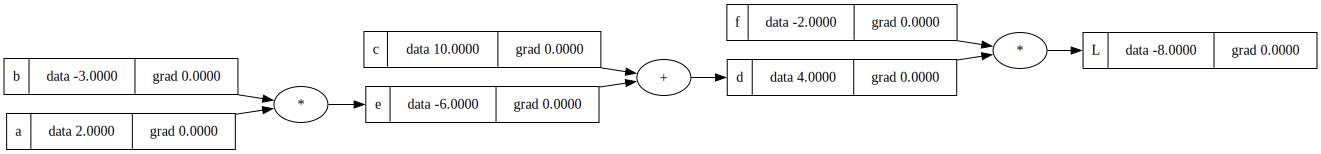

In [95]:
draw_dot(L)

<div class='alert-success'>

- If a local operation is '+', the local derivative is 1.0, and the gradient simply flows through - think of it as a distributor of the gradient
    - Think d = c + e
        - dd/dc = 1

- To back propagate, we use the chain rule, so dL/dc = (dL / dd) * (dd / dc) = (dL / dd) * 1

- Therefore, think of a '+' operaitons as routing the gradient backwards without affecting it (i.e. multiply by 1)

- Overall, backpropataion is the recursive implementation of the chain rule bcakward through the computation graph.

</div>

In [98]:
# Nudging all the values in the direction of the gradient (rmb gradient always points to higher values of the fxn; the gradient itself can be negative)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [97]:
def lol():
    """Define all these vars within the function scope s.t. they do not affect the actualy global scope."""

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

0.0


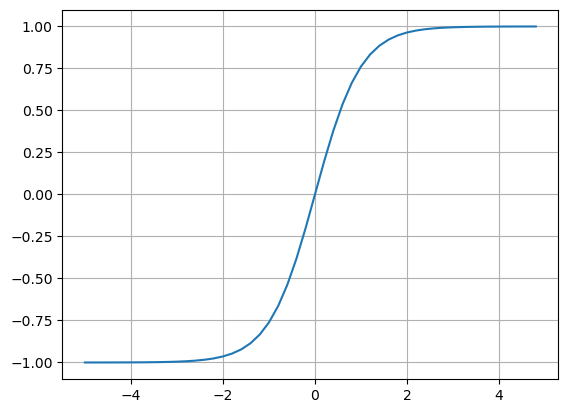

In [100]:
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,.2))); plt.grid();

In [156]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

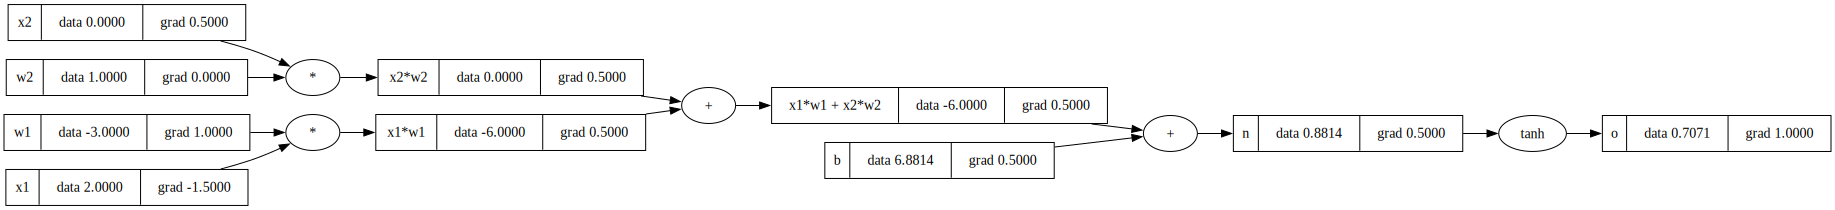

In [161]:
draw_dot(o)

In [160]:
o.backward()

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

<div class='alert-success'>

- We use topological sort to get Direct Acyclic Graph (DAG). Think of it as we are laying out the nodes s.t. it goes from left to right in one direction.

</div>

In [132]:
o.grad = 1.0
o._backward()

In [ ]:
n._backward()

In [140]:
x1w1x2w2._backward()

In [143]:
x1w1._backward()
x2w2._backward()

In [125]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [124]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [120]:
x1w1.grad = .5
x2w2.grad = .5

In [118]:
x1w1x2w2.grad = .5
b.grad = .5

In [116]:
n.grad = .5

In [113]:
o.grad = 1.0

In [115]:
1-o.data**2

0.4999999999999999